In [4]:
import os

import jax
import jax.numpy as jnp
from scipy.optimize import curve_fit
from chex import PRNGKey
import matplotlib.pyplot as plt
import pandas as pd

from mapc_research.plots import confidence_interval, set_style
from mapc_research.scalability import *

In [45]:
db_path = "/Users/wciezobka/ncn/mapc-optimal-research/mapc_research/scalability/database/test_cplex.csv"
df = pd.read_csv(db_path)

In [47]:
df["n_aps"] = df["x_aps"] * df["y_aps"]

# Remove row 32
df = df.drop([32, 42])

# Sort by n_aps
df = df.sort_values(by="n_aps")
df

,start_timestamp,n_sta_per_ap,x_aps,y_aps,repetition,seed,time,n_aps
0,2024-07-08 14:14:14,4,2,1,1,649945706,0.086536,2
1,2024-07-08 14:14:14,4,2,1,2,2039256700,0.058504,2
2,2024-07-08 14:14:14,4,2,1,3,1815804890,0.055099,2
3,2024-07-08 14:14:14,4,2,1,4,1206202644,0.048831,2
4,2024-07-08 14:14:14,4,2,1,5,840030485,0.094332,2
5,2024-07-08 14:14:14,4,3,1,1,649945706,0.188524,3
6,2024-07-08 14:14:14,4,3,1,2,2039256700,0.191240,3
7,2024-07-08 14:14:14,4,3,1,3,1815804890,0.171181,3
8,2024-07-08 14:14:14,4,3,1,4,1206202644,0.189239,3
9,2024-07-08 14:14:14,4,3,1,5,840030485,0.209590,3


In [57]:
def plot_results(df: pd.DataFrame, log_space: bool = False):

    # Unpack results
    aps = df["n_aps"].unique()
    times_mean = df.groupby('n_aps').mean().reset_index()["time"].values
    times_ci_low = df.groupby('n_aps').apply(lambda x: confidence_interval(x, ci=0.95)[1])["time"].values
    times_ci_high = df.groupby('n_aps').apply(lambda x: confidence_interval(x, ci=0.95)[2])["time"].values
    scale = 0.
    exponent = 1.

    # Define resolution for fitted curve
    xs = jnp.linspace(0, aps[-1], 100)

    # Plot results
    set_style()
    plt.figure(figsize=(4,3))
    plt.scatter(aps, times_mean, c="C0", label="Data", marker="x")
    plt.fill_between(aps, times_ci_low, times_ci_high, color="C0", alpha=0.3)
    plt.plot(
        xs, -scale + scale*jnp.power(exponent, xs),
        c="tab:grey", linestyle="--", linewidth=0.5, label=f"Fit"
    )
    plt.yscale("log" if log_space else "linear")
    plt.xlabel("Number of access points")
    plt.ylabel("Execution time [s]")
    plt.legend()
    plt.title(f"scale = {scale:.5f}, exponent = {exponent:.5f}")
    plt.tight_layout()
    plt.savefig(os.path.join(f"test_cplex.pdf"))

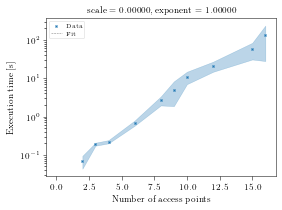

In [59]:
plot_results(df[["n_aps", "time"]], log_space=True)